In [16]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Variables


In [2]:
num_topics = 5
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data loading and preparation

## load

In [31]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus
corpus = load_data()

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [32]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
17it [00:00, 166.68it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:06, 191.55it/s]


### tfidf

The TfidfVectorizer does additionally also tokenization and stop word removal.

In [33]:
vectorizer_sklearn = TfidfVectorizer(stop_words='english')
tfidf_corpus_sklearn_preprocessed = vectorizer_sklearn.fit_transform(corpus["abstract"])

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Since we implemented our own preprocessing this is not necessary. Therefore we don't use tokenization and lowercase. Since we didn't implement stop word removal yet(TODO: false -> remove stopword removal by sklearn) we use the stopword removal by sklearn.

In [34]:
def identity_tokenizer(text):
    return text

def get_tfidf_corpus(corpus):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
    return vectorizer, vectorizer.fit_transform(corpus["token"])

vectorizer, tfidf_corpus = get_tfidf_corpus(corpus)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## get optimal k

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


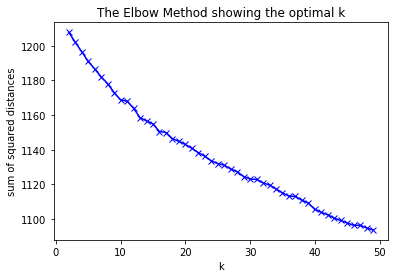

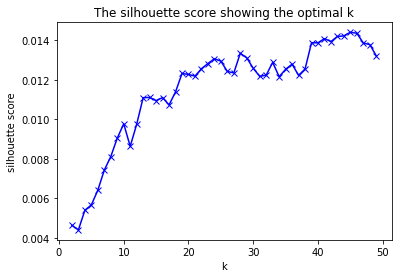

In [7]:
def find_k(corpus, num_topics):
    sum_of_suared_distances = []
    silhouette_scores = []
    K = range(2,num_topics)
    for k in K:
        model = KMeans(n_clusters=k, random_state=10)
        model.fit(corpus)
        sum_of_suared_distances.append(model.inertia_)
        labels = model.labels_
        silhouette_scores.append(metrics.silhouette_score(tfidf_corpus, labels, metric='euclidean'))

    # Plot the elbow
    plt.plot(K, sum_of_suared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('sum of squared distances')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    # Plot silhouette scores
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.title('The silhouette score showing the optimal k')
    plt.show()
find_k(tfidf_corpus, 50)

 There is no elbow visible. There could be several reasons for this: https://stats.stackexchange.com/questions/89679/what-do-you-do-when-theres-no-elbow-point-for-kmeans-clustering

Silhouette score explained:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
TODO: proper visualization of silhouette score

Elbow Method explained: https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/

# Clustering

In [19]:
def fit_model(model, corpus):
    model.fit(corpus)

def print_and_get_clusters(model, vectorizer, n_components=None, svd=None):
    print("Top terms per cluster:")
    if n_components:
        original_space_centroids = svd.inverse_transform(model.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    clusters = []
    for i in range(num_topics):
        print("Cluster %d:" % i),
        cluster = []
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
            cluster.append(terms[ind])
        clusters.append(cluster)
        print("\n")
    return clusters
    
model = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model, tfidf_corpus)
clusters = print_and_get_clusters(model, vectorizer)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 factorization
 machine
 ranking
 matrix
 learning
 implementation
 pairwise
 library
 model
 data


Cluster 1:
 matrix
 rank
 low
 completion
 method
 sampling
 bound
 covariance
 data
 norm


Cluster 2:
 network
 neural
 representation
 deep
 model
 data
 layer
 learning
 image
 gesture


Cluster 3:
 learning
 policy
 algorithm
 problem
 loss
 function
 bound
 regret
 class
 method


Cluster 4:
 bayesian
 posterior
 topic
 model
 prior
 carlo
 monte
 distribution
 markov
 inference


Cluster 5:
 causal
 effect
 variable
 observational
 discovery
 cause
 data
 interventional
 treatment
 model


Cluster 6:
 model
 graph
 data
 graphical
 variable
 algorithm
 latent
 feature
 method
 selection


Cluster 7:
 regression
 estimator
 derivative
 estimation
 lasso
 model
 response
 least
 method
 linear


Cluster 8:
 svm
 vector
 norm
 support
 classification
 high
 dictionary
 coefficient
 sparse
 classifier


Cluster 9:
 clustering
 cluster
 algorithm
 den

Since the words which define the clusters look weird I use the sklearn preprocessing in the following. Our preprocessing should be improved. Or we decide to just use the sklearn preprocessing. But as far as I know they don't use lemmatization and stemming (TODO: true?)
With no stemming, the use of nltk and lowering the words, the result seems to be better. Therfore we use our own preprocessing again.

In [20]:
model_skelarn_preprocessed = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_skelarn_preprocessed, tfidf_corpus_sklearn_preprocessed)
print_and_get_clusters(model_skelarn_preprocessed, vectorizer_sklearn)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 dictionary
 optimal
 local
 multiscale
 recovery
 bounds
 chervonenkis
 bibliography
 alexey
 compressed


Cluster 1:
 loss
 function
 optimization
 problems
 losses
 convex
 problem
 functions
 dual
 learning


Cluster 2:
 clustering
 clusters
 cluster
 density
 algorithm
 data
 graph
 number
 tensor
 hierarchical


Cluster 3:
 causal
 graph
 graphs
 variables
 data
 observational
 effect
 effects
 learning
 discovery


Cluster 4:
 gaussian
 models
 graphical
 process
 inference
 variational
 model
 gp
 processes
 covariance


Cluster 5:
 gradient
 stochastic
 optimization
 convex
 convergence
 descent
 methods
 algorithms
 method
 problems


Cluster 6:
 selection
 model
 feature
 high
 dimensional
 data
 sparse
 lasso
 covariance
 method


Cluster 7:
 neural
 networks
 gesture
 recognition
 deep
 network
 convolutional
 training
 data
 layers


Cluster 8:
 data
 models
 model
 inference
 latent
 learning
 bayesian
 time
 algorithms
 analysis


Clust

[['dictionary',
  'optimal',
  'local',
  'multiscale',
  'recovery',
  'bounds',
  'chervonenkis',
  'bibliography',
  'alexey',
  'compressed'],
 ['loss',
  'function',
  'optimization',
  'problems',
  'losses',
  'convex',
  'problem',
  'functions',
  'dual',
  'learning'],
 ['clustering',
  'clusters',
  'cluster',
  'density',
  'algorithm',
  'data',
  'graph',
  'number',
  'tensor',
  'hierarchical'],
 ['causal',
  'graph',
  'graphs',
  'variables',
  'data',
  'observational',
  'effect',
  'effects',
  'learning',
  'discovery'],
 ['gaussian',
  'models',
  'graphical',
  'process',
  'inference',
  'variational',
  'model',
  'gp',
  'processes',
  'covariance'],
 ['gradient',
  'stochastic',
  'optimization',
  'convex',
  'convergence',
  'descent',
  'methods',
  'algorithms',
  'method',
  'problems'],
 ['selection',
  'model',
  'feature',
  'high',
  'dimensional',
  'data',
  'sparse',
  'lasso',
  'covariance',
  'method'],
 ['neural',
  'networks',
  'gesture',
 

lemmatization would be good, because the defining words are redundant(e.g. models and model, graphs and graph, ...)

# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


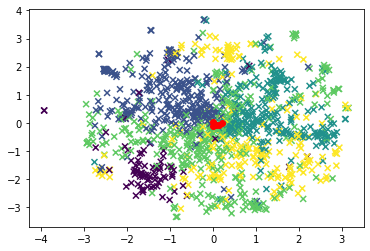

In [10]:
def plot(model, corpus, n_components=None):
    random_state = 1
    centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(np.concatenate((corpus, centroids)))
    else:
        transformed = tsne.fit_transform(np.concatenate((corpus.todense(), centroids)))
    plt.scatter(transformed[:-num_topics, 0], transformed[:-num_topics, 1], c=model.labels_, marker='x')
    plt.scatter(transformed[-num_topics:, 0], transformed[-num_topics:, 1], c="red", marker='o')

    plt.show()
plot(model, tfidf_corpus)

# LSA and kmeans

In [11]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


n_components:  2


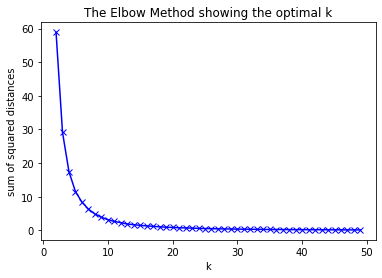

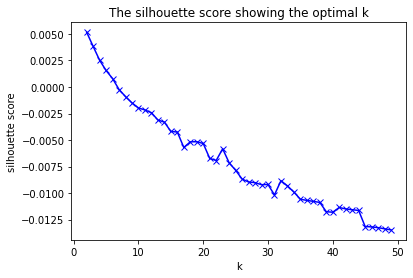

n_components:  3


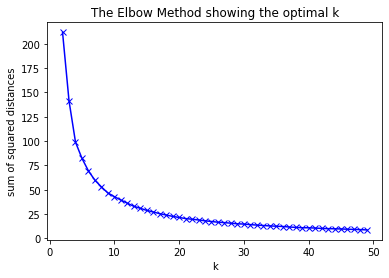

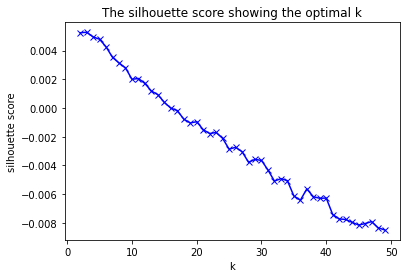

n_components:  4


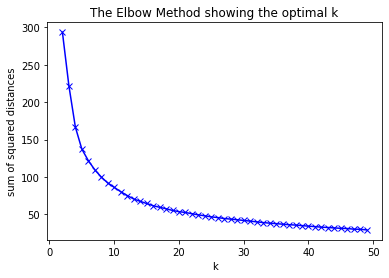

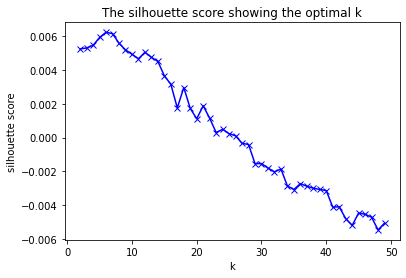

n_components:  5


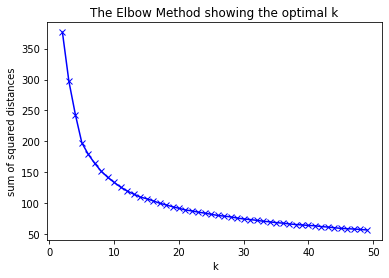

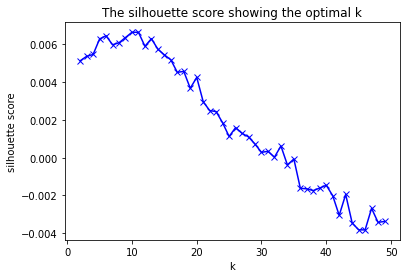

n_components:  6


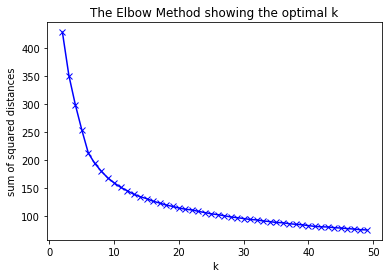

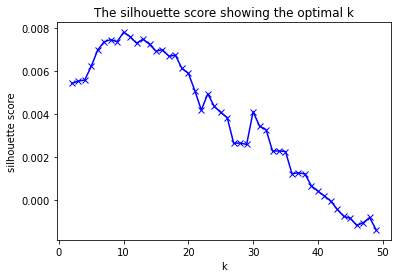

n_components:  7


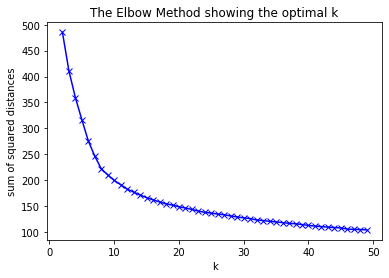

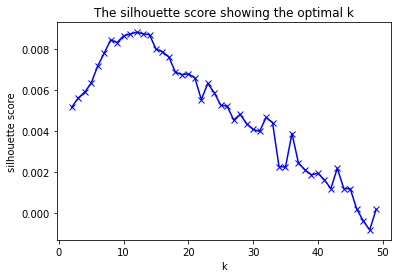

n_components:  8


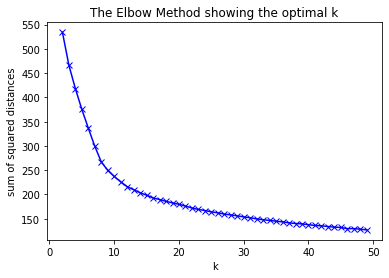

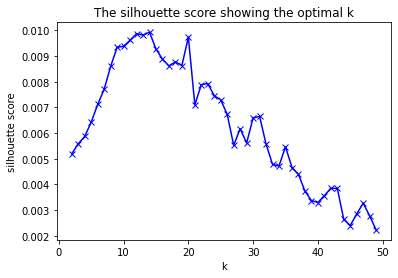

n_components:  9


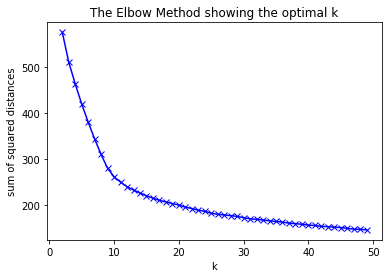

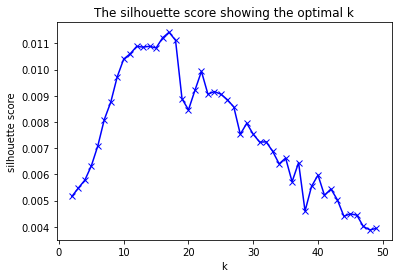

n_components:  10


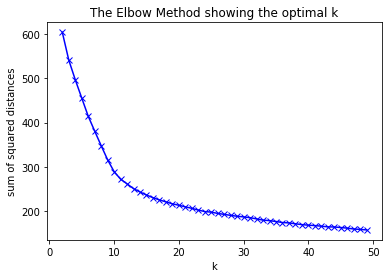

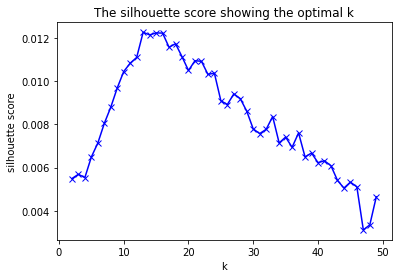

In [12]:
def find_n_components_and_k(corpus):
    for n_components in [2,3,4,5,6,7,8,9,10]:
        print("n_components: ", n_components)
        X, svd = get_lsa_transformation(n_components, corpus)
        find_k(X, 50)
        
find_n_components_and_k(tfidf_corpus)

With LSA and kmeans a elbow is visible! The peak of the silhouette score moves to the right the higher n_component.
The optimal cluster number seems to be 15? With n_components = 10 also the peak of the silhouette score is at k=15. So maybe use num_topics= 15 and n_components=9?

In [21]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus)
num_topics = 15
model = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model, X)
clusters_with_lsa = print_and_get_clusters(model, vectorizer, n_components=n_components, svd=svd)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 model
 data
 method
 regression
 matrix
 algorithm
 estimator
 problem
 learning
 approach


Cluster 1:
 learning
 data
 label
 classification
 algorithm
 feature
 problem
 model
 task
 set


Cluster 2:
 network
 model
 neural
 node
 deep
 learning
 community
 structure
 layer
 graphical


Cluster 3:
 clustering
 cluster
 density
 algorithm
 graph
 data
 spectral
 based
 point
 number


Cluster 4:
 matrix
 rank
 low
 completion
 bound
 tensor
 norm
 sparse
 problem
 approximation


Cluster 5:
 bound
 loss
 learning
 rate
 sample
 algorithm
 estimator
 class
 function
 distribution


Cluster 6:
 regression
 estimator
 model
 rate
 method
 estimation
 data
 loss
 high
 dimensional


Cluster 7:
 graph
 model
 network
 graphical
 data
 causal
 variable
 gaussian
 inference
 algorithm


Cluster 8:
 policy
 learning
 algorithm
 bound
 distribution
 reinforcement
 action
 regret
 process
 problem


Cluster 9:
 algorithm
 optimization
 gradient
 convex
 stoch

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


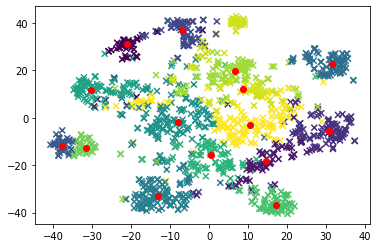

In [14]:
plot(model, X, n_components=n_components)

cluster centers look better than without lsa.

# Remove words which appear often in all clusters

In [22]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Counter.most_common of Counter({'data': 8, 'model': 7, 'learning': 5, 'method': 5, 'algorithm': 5, 'bound': 3, 'problem': 3, 'function': 3, 'matrix': 2, 'library': 2, 'norm': 2, 'loss': 2, 'bayesian': 2, 'inference': 2, 'variable': 2, 'graph': 2, 'regression': 2, 'estimator': 2, 'based': 2, 'rate': 2, 'factorization': 1, 'machine': 1, 'ranking': 1, 'implementation': 1, 'pairwise': 1, 'rank': 1, 'low': 1, 'completion': 1, 'sampling': 1, 'covariance': 1, 'network': 1, 'neural': 1, 'representation': 1, 'deep': 1, 'layer': 1, 'image': 1, 'gesture': 1, 'policy': 1, 'regret': 1, 'class': 1, 'posterior': 1, 'topic': 1, 'prior': 1, 'carlo': 1, 'monte': 1, 'distribution': 1, 'markov': 1, 'causal': 1, 'effect': 1, 'observational': 1, 'discovery': 1, 'cause': 1, 'interventional': 1, 'treatment': 1, 'graphical': 1, 'latent': 1, 'feature': 1, 'selection': 1, 'derivative': 1, 'estimation': 1, 'lasso': 1, 'response': 1, 'least': 1, 'linear': 1, 'svm': 1, 'vector': 1, 'support': 1, 'clas

In [23]:
terms = list(itertools.chain.from_iterable(clusters_with_lsa))
Counter(terms).most_common

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Counter.most_common of Counter({'data': 9, 'learning': 9, 'model': 8, 'algorithm': 8, 'problem': 6, 'method': 5, 'estimator': 4, 'graphical': 4, 'graph': 4, 'bound': 4, 'regression': 3, 'network': 3, 'rate': 3, 'function': 3, 'causal': 3, 'variable': 3, 'inference': 3, 'matrix': 2, 'classification': 2, 'feature': 2, 'task': 2, 'node': 2, 'clustering': 2, 'cluster': 2, 'loss': 2, 'distribution': 2, 'gaussian': 2, 'process': 2, 'latent': 2, 'approach': 1, 'label': 1, 'set': 1, 'neural': 1, 'deep': 1, 'community': 1, 'structure': 1, 'layer': 1, 'density': 1, 'spectral': 1, 'based': 1, 'point': 1, 'number': 1, 'rank': 1, 'low': 1, 'completion': 1, 'tensor': 1, 'norm': 1, 'sparse': 1, 'approximation': 1, 'sample': 1, 'class': 1, 'estimation': 1, 'high': 1, 'dimensional': 1, 'policy': 1, 'reinforcement': 1, 'action': 1, 'regret': 1, 'optimization': 1, 'gradient': 1, 'convex': 1, 'stochastic': 1, 'convergence': 1, 'descent': 1, 'effect': 1, 'bayesian': 1, 'variational': 1, 'mach

Words that should be removed are algorithm, data, learning, method, model. This insight corresponds to the insight we get by printing the topwords of BoW and tfidf corpuses (milestone) 

In [24]:
custom_stopwords = ["algorithm", "data", "learning", "method", "model"]

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
corpus = load_data()

corpus_stopwords = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
20it [00:00, 197.98it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:06, 187.08it/s]


In [35]:
vectorizer_stopwords, tfidf_corpus_stopwords = get_tfidf_corpus(corpus_stopwords)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus_stopwords)
num_topics = 15
model_stopwords = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_stopwords, X)
clusters_with_lsa_stopwords = print_and_get_clusters(model_stopwords, vectorizer_stopwords, n_components=n_components, svd=svd)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 kernel
 regression
 function
 estimator
 space
 rate
 mean
 density
 square
 least


Cluster 1:
 inference
 bayesian
 gaussian
 process
 variational
 approximation
 distribution
 latent
 posterior
 approach


Cluster 2:
 feature
 classification
 set
 label
 machine
 problem
 task
 approach
 multi
 class


Cluster 3:
 matrix
 rank
 problem
 bound
 sparse
 low
 approach
 estimator
 regression
 estimation


Cluster 4:
 label
 bound
 classification
 class
 problem
 loss
 classifier
 sample
 risk
 set


Cluster 5:
 feature
 machine
 library
 classification
 python
 task
 multi
 label
 source
 set


Cluster 6:
 optimization
 gradient
 convex
 stochastic
 problem
 function
 convergence
 descent
 objective
 non


Cluster 7:
 network
 neural
 node
 deep
 community
 structure
 layer
 time
 training
 graph


Cluster 8:
 regression
 estimator
 kernel
 rate
 variable
 high
 dimensional
 lasso
 linear
 selection


Cluster 9:
 bound
 rate
 estimator
 distribution
 l

In [37]:
terms = list(itertools.chain.from_iterable(clusters_with_lsa_stopwords))
Counter(terms).most_common

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method Counter.most_common of Counter({'problem': 6, 'bound': 6, 'estimator': 4, 'label': 4, 'graph': 4, 'regression': 3, 'function': 3, 'rate': 3, 'approximation': 3, 'approach': 3, 'classification': 3, 'set': 3, 'class': 3, 'matrix': 3, 'kernel': 2, 'space': 2, 'density': 2, 'gaussian': 2, 'process': 2, 'distribution': 2, 'latent': 2, 'feature': 2, 'machine': 2, 'task': 2, 'multi': 2, 'rank': 2, 'sparse': 2, 'low': 2, 'loss': 2, 'sample': 2, 'risk': 2, 'network': 2, 'node': 2, 'variable': 2, 'dimensional': 2, 'lasso': 2, 'selection': 2, 'clustering': 2, 'cluster': 2, 'based': 2, 'graphical': 2, 'causal': 2, 'mean': 1, 'square': 1, 'least': 1, 'inference': 1, 'bayesian': 1, 'variational': 1, 'posterior': 1, 'estimation': 1, 'classifier': 1, 'library': 1, 'python': 1, 'source': 1, 'optimization': 1, 'gradient': 1, 'convex': 1, 'stochastic': 1, 'convergence': 1, 'descent': 1, 'objective': 1, 'non': 1, 'neural': 1, 'deep': 1, 'community': 1, 'structure': 1, 'layer': 1, 'time': 1, 

Now we have other words that are in multiple clusters.

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


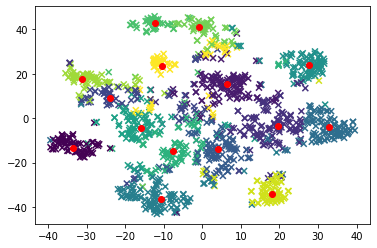

In [38]:
plot(model_stopwords, X, n_components=n_components)

The clusters look now not as good as before in my opinion. Maybe we need new k and n_components?

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


n_components:  2


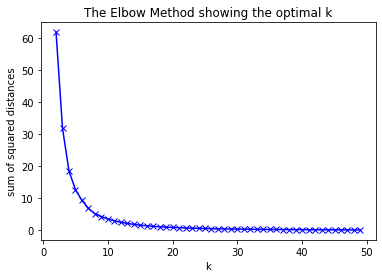

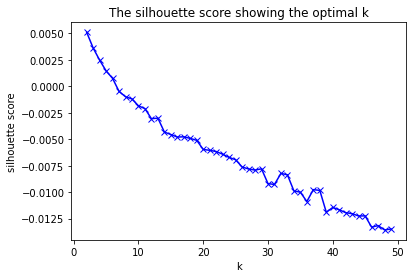

n_components:  3


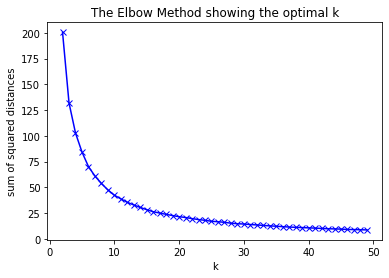

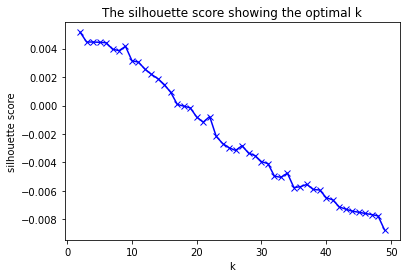

n_components:  4


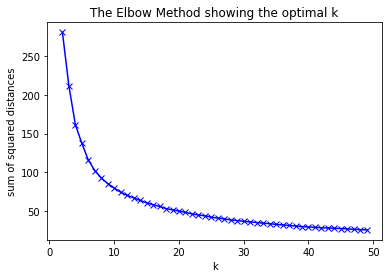

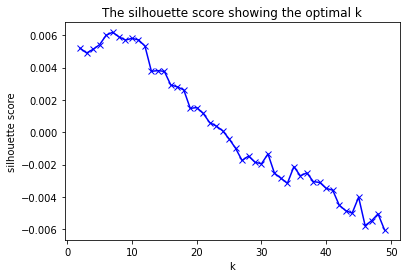

n_components:  5


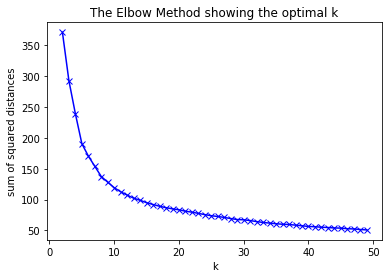

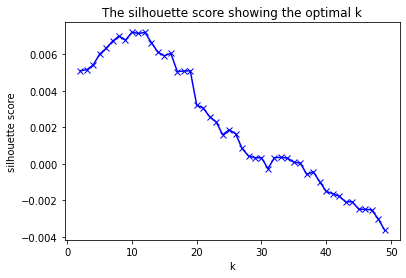

n_components:  6


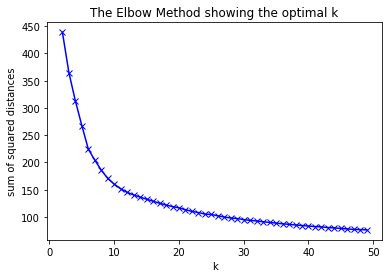

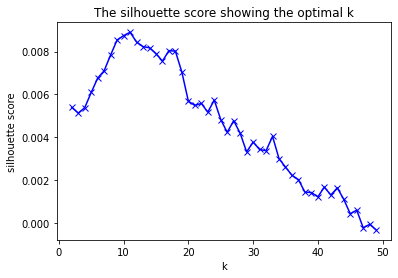

n_components:  7


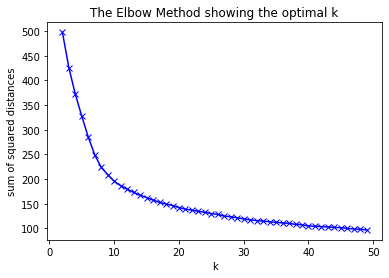

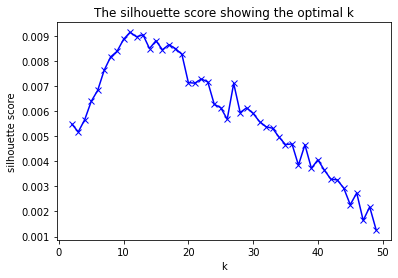

n_components:  8


In [ ]:
find_n_components_and_k(tfidf_corpus_stopwords)

Looks similar to before.